# BACE1 Inhibitor Analysis and Drug Design

### 1. Data Preparation and Molecular Representation

### 2. Structural Feature Detection

### 3. Structure-Activity Relationship (SAR) Analysis

### 4. Visualization of Molecular Structures

### 5. Statistical Analysis

### 6. Correlation Analysis


In [57]:
! pip install chembl_webresource_client

In [58]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

In [59]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [60]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [61]:
type(targets_api)

chembl_webresource_client.query_set.QuerySet

In [62]:
compounds_api = new_client.molecule

In [63]:
type(compounds_api)

chembl_webresource_client.query_set.QuerySet

In [64]:
type(bioactivities_api)

chembl_webresource_client.query_set.QuerySet

In [65]:
from chembl_webresource_client.new_client import new_client

targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

uniprot_id = "P56817"
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)

# Select the 'SINGLE PROTEIN' target
target = next((t for t in targets if t['target_type'] == 'SINGLE PROTEIN'), None)

if target:
    chembl_id = target["target_chembl_id"]
    print(f"The target ChEMBL ID is {chembl_id}")
    print(f"Target name: {target['pref_name']}")
else:
    print("No suitable target found for the given UniProt ID")

The target ChEMBL ID is CHEMBL4822
Target name: Beta-secretase 1


In [66]:
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

bioactivities_df = pd.DataFrame.from_dict(bioactivities)
print(f"Bioactivities DataFrame shape: {bioactivities_df.shape}")

Bioactivities DataFrame shape: (9794, 13)


In [31]:
# Remove entries with missing values
bioactivities_df.dropna(inplace=True)

# Keep only entries with "nM" as the standard unit
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]

# Remove duplicates
bioactivities_df.drop_duplicates(subset="molecule_chembl_id", keep="first", inplace=True)

print(f"Processed bioactivities DataFrame shape: {bioactivities_df.shape}")

Processed bioactivities DataFrame shape: (6882, 13)


In [32]:
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

compounds = list(compounds_provider)
compounds_df = pd.DataFrame.from_records(compounds)

# Extract SMILES
compounds_df['smiles'] = compounds_df['molecule_structures'].apply(lambda x: x['canonical_smiles'] if x and 'canonical_smiles' in x else None)
compounds_df = compounds_df.dropna(subset=['smiles'])

print(f"Compounds DataFrame shape: {compounds_df.shape}")

Compounds DataFrame shape: (6882, 3)


In [36]:
import pandas as pd
import numpy as np
import math

# Convert 'IC50' column to numeric, coercing errors to NaN
output_df['IC50'] = pd.to_numeric(output_df['IC50'], errors='coerce')

# Remove rows with NaN values in the 'IC50' column
output_df = output_df.dropna(subset=['IC50'])

print(f"Dataset shape after cleaning IC50 values: {output_df.shape}")

Dataset shape after cleaning IC50 values: (6882, 4)


In [37]:
def calculate_pIC50(ic50):
    try:
        return -math.log10(ic50 * 1e-9)
    except (ValueError, TypeError):
        return np.nan

# Apply the function to calculate pIC50
output_df["pIC50"] = output_df["IC50"].apply(calculate_pIC50)

# Remove rows with NaN pIC50 values
output_df = output_df.dropna(subset=['pIC50'])

print(f"Final dataset shape: {output_df.shape}")

Final dataset shape: (6882, 5)


In [38]:
print(output_df.dtypes)
print("\nSample of the data:")
print(output_df.head())

# Basic statistics of IC50 and pIC50
print("\nBasic statistics of IC50 and pIC50:")
print(output_df[['IC50', 'pIC50']].describe())

molecule_chembl_id     object
IC50                  float64
units                  object
smiles                 object
pIC50                 float64
dtype: object

Sample of the data:
  molecule_chembl_id    IC50 units  \
0       CHEMBL406146   413.0    nM   
1        CHEMBL78946     2.0    nM   
2       CHEMBL324109   460.0    nM   
3       CHEMBL114147  9000.0    nM   
4       CHEMBL419949  5600.0    nM   

                                              smiles     pIC50  
0  CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@@H](N)CCC(=O...  6.384050  
1  CC(C)C[C@H](NC(=O)[C@H](CC(N)=O)NC(=O)[C@@H](N...  8.698970  
2  CCC(C)C[C@H](NC(=O)[C@H](CC(C)C)NC(C)=O)[C@@H]...  6.337242  
3  CC(=O)NCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)CC(=O)...  5.045757  
4  CC(=O)N[C@@H](Cc1ccccc1)C(=O)N[C@@H](Cc1ccccc1...  5.251812  

Basic statistics of IC50 and pIC50:
               IC50        pIC50
count  6.882000e+03  6882.000000
mean   2.297780e+04     6.625417
std    4.727443e+05     1.326152
min    2.000000e-04     1.4

In [39]:
# Sort the dataset by pIC50 values
output_df = output_df.sort_values(by="pIC50", ascending=False)

# Reset the index
output_df = output_df.reset_index(drop=True)

print("\nTop 5 compounds by pIC50:")
print(output_df.head())

# Save the dataset
output_df.to_csv("BACE1_compounds.csv", index=False)
print("\nDataset saved as BACE1_compounds.csv")


Top 5 compounds by pIC50:
  molecule_chembl_id    IC50 units  \
0      CHEMBL3969403  0.0002    nM   
1      CHEMBL3937515  0.0009    nM   
2      CHEMBL3949213  0.0010    nM   
3      CHEMBL3955051  0.0018    nM   
4      CHEMBL3936264  0.0057    nM   

                                              smiles      pIC50  
0  CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3ccc(C#N)cn3)c...  12.698970  
1  COc1cnc(C(=O)Nc2ccc(F)c([C@]3(C)CS(=O)(=O)C(C)...  12.045757  
2  C[C@@]1(c2cc(NC(=O)c3ccc(C#N)cn3)ccc2F)CS(=O)(...  12.000000  
3  CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3cnc(C(F)F)cn3...  11.744727  
4  C[C@@]1(c2cc(NC(=O)c3ccc(OC(F)F)cn3)ccc2F)CS(=...  11.244125  

Dataset saved as BACE1_compounds.csv


In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(output_df['pIC50'], bins=30, edgecolor='black')
plt.title('Distribution of pIC50 Values for BACE1 Inhibitors')
plt.xlabel('pIC50')
plt.ylabel('Frequency')
plt.savefig('BACE1_pIC50_distribution.png')
plt.close()

print("Histogram of pIC50 values saved as BACE1_pIC50_distribution.png")

Histogram of pIC50 values saved as BACE1_pIC50_distribution.png


In [41]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, PandasTools
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("BACE1_compounds.csv")

# Add RDKit Mol object column
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='smiles')

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (6882, 6)


,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol
0,CHEMBL3969403,0.0002,nM,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3ccc(C#N)cn3)c...,12.698970,<rdkit.Chem.rdchem.Mol object at 0x7799bbc228f0>
1,CHEMBL3937515,0.0009,nM,COc1cnc(C(=O)Nc2ccc(F)c([C@]3(C)CS(=O)(=O)C(C)...,12.045757,<rdkit.Chem.rdchem.Mol object at 0x7799bbc22960>
2,CHEMBL3949213,0.0010,nM,C[C@@]1(c2cc(NC(=O)c3ccc(C#N)cn3)ccc2F)CS(=O)(...,12.000000,<rdkit.Chem.rdchem.Mol object at 0x7799bbc229d0>
3,CHEMBL3955051,0.0018,nM,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3cnc(C(F)F)cn3...,11.744727,<rdkit.Chem.rdchem.Mol object at 0x7799bbc22a40>
4,CHEMBL3936264,0.0057,nM,C[C@@]1(c2cc(NC(=O)c3ccc(OC(F)F)cn3)ccc2F)CS(=...,11.244125,<rdkit.Chem.rdchem.Mol object at 0x7799bbc22ab0>


In [42]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, PandasTools
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("BACE1_compounds.csv")

# Add RDKit Mol object column
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='smiles')

print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (6882, 6)


,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol
0,CHEMBL3969403,0.0002,nM,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3ccc(C#N)cn3)c...,12.698970,<rdkit.Chem.rdchem.Mol object at 0x7799bcd549e0>
1,CHEMBL3937515,0.0009,nM,COc1cnc(C(=O)Nc2ccc(F)c([C@]3(C)CS(=O)(=O)C(C)...,12.045757,<rdkit.Chem.rdchem.Mol object at 0x7799bcd54a50>
2,CHEMBL3949213,0.0010,nM,C[C@@]1(c2cc(NC(=O)c3ccc(C#N)cn3)ccc2F)CS(=O)(...,12.000000,<rdkit.Chem.rdchem.Mol object at 0x7799bcd54ac0>
3,CHEMBL3955051,0.0018,nM,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3cnc(C(F)F)cn3...,11.744727,<rdkit.Chem.rdchem.Mol object at 0x7799bcd54b30>
4,CHEMBL3936264,0.0057,nM,C[C@@]1(c2cc(NC(=O)c3ccc(OC(F)F)cn3)ccc2F)CS(=...,11.244125,<rdkit.Chem.rdchem.Mol object at 0x7799bcd54ba0>


In [45]:
from rdkit import Chem
from rdkit.Chem import Descriptors

def calculate_descriptors(mol):
    return {
        'MolWt': Descriptors.ExactMolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'NumHDonors': Descriptors.NumHDonors(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),
        'NumRotatableBonds': Descriptors.NumRotatableBonds(mol),
        'TPSA': Descriptors.TPSA(mol)
    }

# Calculate descriptors for each molecule
descriptor_df = df['ROMol'].apply(calculate_descriptors).apply(pd.Series)

# Combine the original dataframe with the new descriptors
df = pd.concat([df, descriptor_df], axis=1)

print(df.columns)

Index(['molecule_chembl_id', 'IC50', 'units', 'smiles', 'pIC50', 'ROMol',
       'MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'NumRotatableBonds',
       'TPSA'],
      dtype='object')


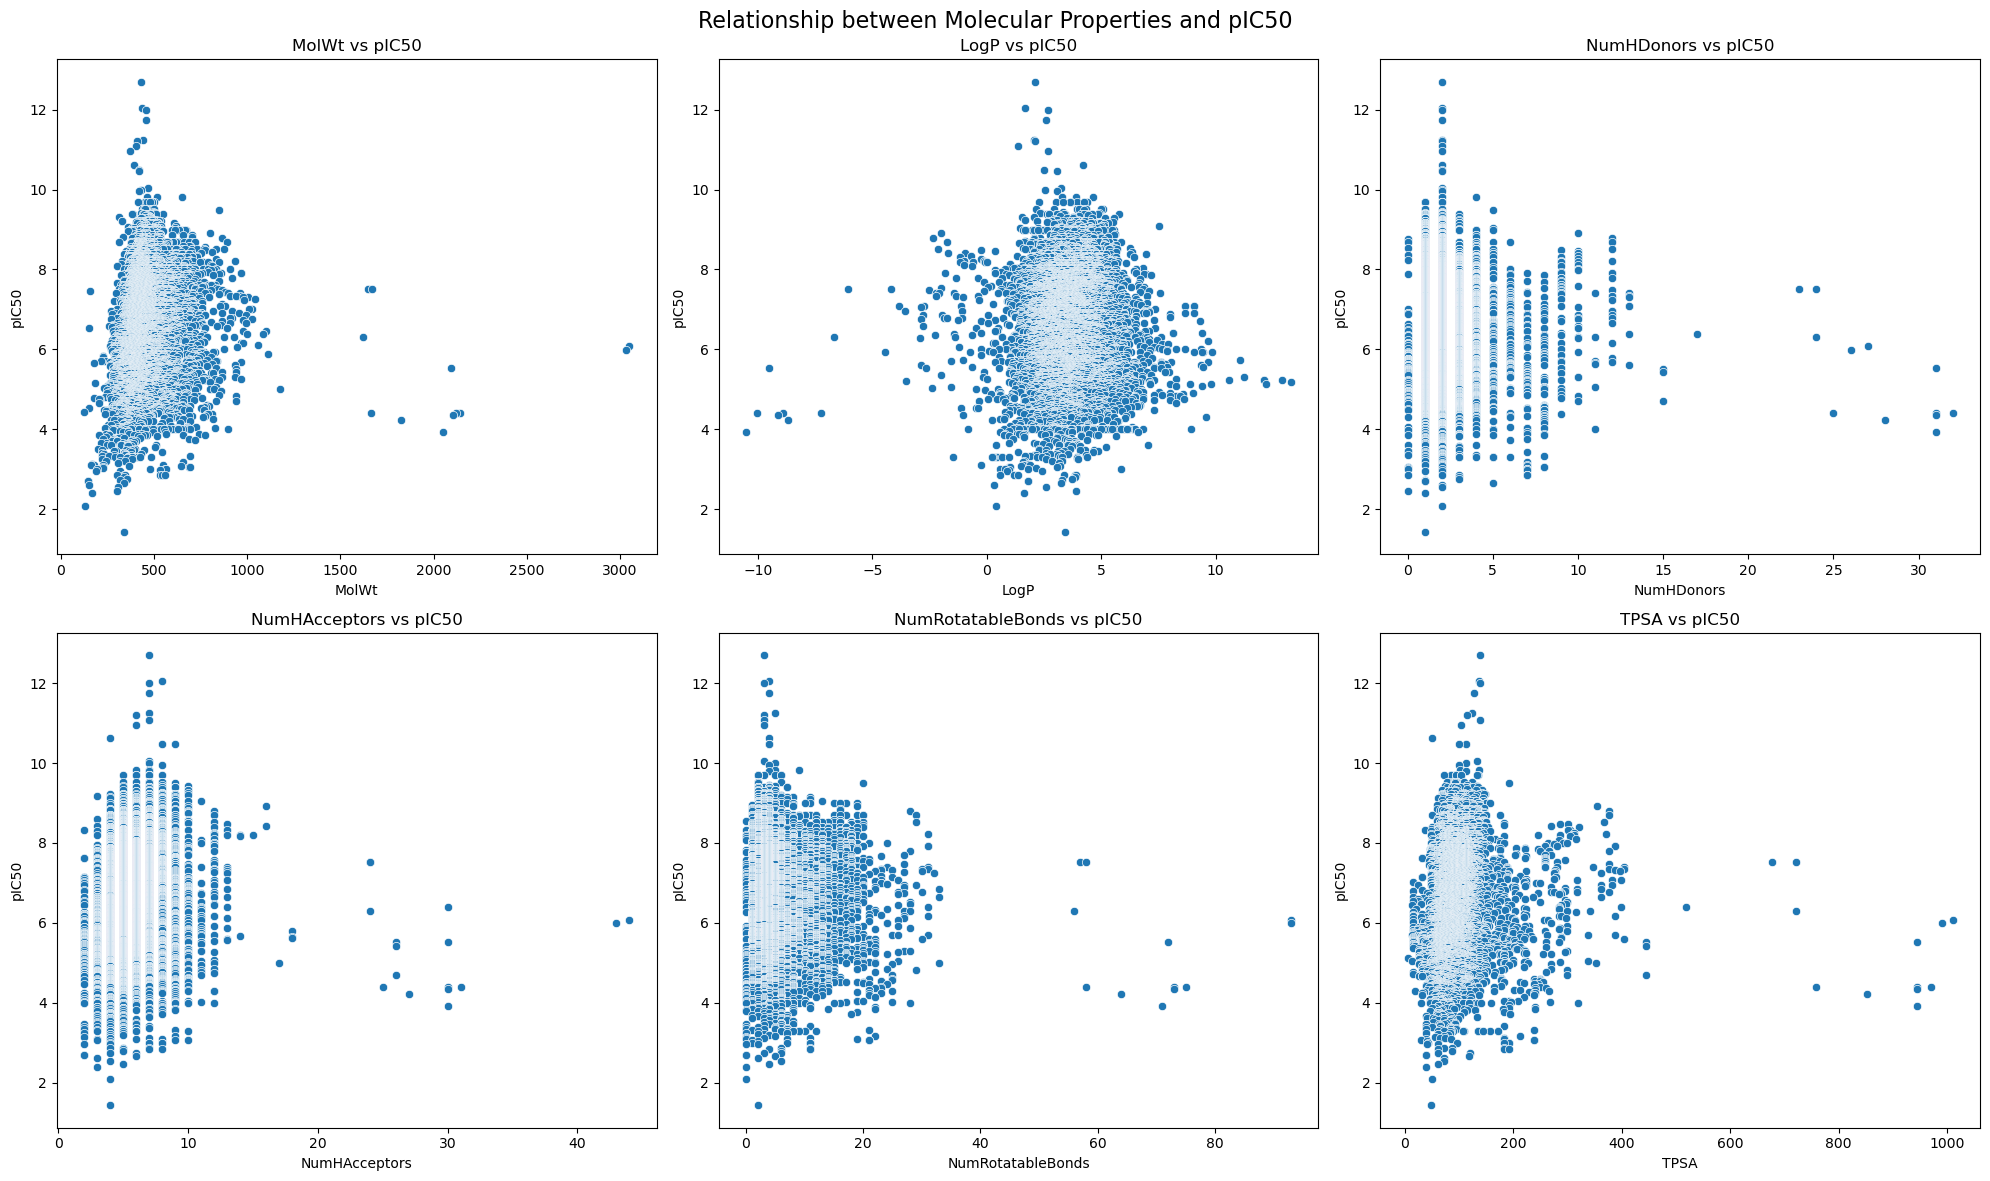

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Relationship between Molecular Properties and pIC50', fontsize=16)

# Plot each molecular descriptor against pIC50
properties = ['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'NumRotatableBonds', 'TPSA']
for i, prop in enumerate(properties):
    row = i // 3
    col = i % 3
    sns.scatterplot(data=df, x=prop, y='pIC50', ax=axs[row, col])
    axs[row, col].set_title(f'{prop} vs pIC50')

plt.tight_layout()
plt.show()

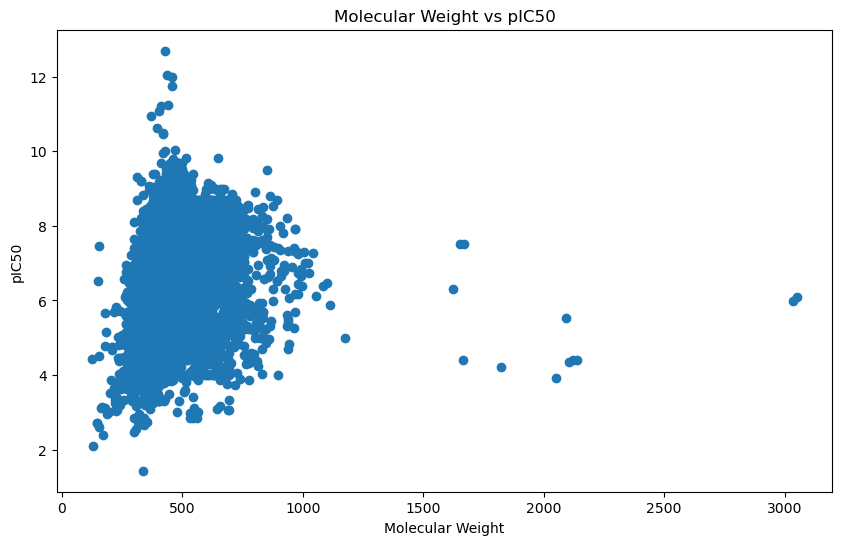

In [48]:
plt.figure(figsize=(10, 6))
plt.scatter(df['MolWt'], df['pIC50'])
plt.xlabel('Molecular Weight')
plt.ylabel('pIC50')
plt.title('Molecular Weight vs pIC50')
plt.show()

In [50]:
print(f"Number of valid RDKit molecules: {df['ROMol'].notna().sum()}")
print(f"Total number of rows: {len(df)}")

Number of valid RDKit molecules: 6882
Total number of rows: 6882


In [53]:
from rdkit import Chem

df['HasCarbon'] = df['ROMol'].apply(lambda x: x.GetSubstructMatch(Chem.MolFromSmarts('C')) != ())

print(f"Molecules with carbon: {df['HasCarbon'].sum()}")
print(f"Molecules without carbon: {(~df['HasCarbon']).sum()}")

Molecules with carbon: 6846
Molecules without carbon: 36


Molecules with carbon: 6846
Molecules without carbon: 36
Molecules with HasAmide: 4585
Molecules without HasAmide: 2297
Average pIC50 with HasAmide: 6.81
Average pIC50 without HasAmide: 6.25

Molecules with HasSulfonamide: 522
Molecules without HasSulfonamide: 6360
Average pIC50 with HasSulfonamide: 6.49
Average pIC50 without HasSulfonamide: 6.64

Molecules with HasAmine: 6591
Molecules without HasAmine: 291
Average pIC50 with HasAmine: 6.68
Average pIC50 without HasAmine: 5.41

Molecule 1:
SMILES: CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3ccc(C#N)cn3)ccc2F)CS1(=O)=O
HasAmide: True
HasSulfonamide: False
HasAmine: True



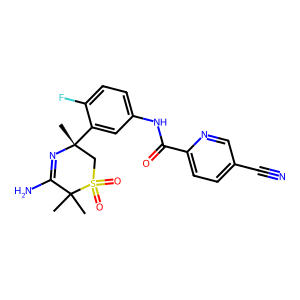


Molecule 2:
SMILES: COc1cnc(C(=O)Nc2ccc(F)c([C@]3(C)CS(=O)(=O)C(C)(C)C(N)=N3)c2)cn1
HasAmide: True
HasSulfonamide: False
HasAmine: True



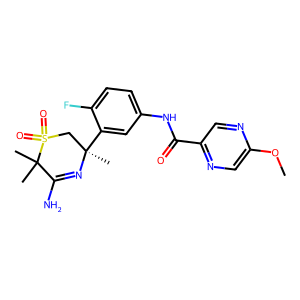


Molecule 3:
SMILES: C[C@@]1(c2cc(NC(=O)c3ccc(C#N)cn3)ccc2F)CS(=O)(=O)C2(CCCC2)C(N)=N1
HasAmide: True
HasSulfonamide: False
HasAmine: True



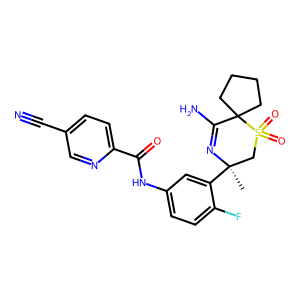


Molecule 4:
SMILES: CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3cnc(C(F)F)cn3)ccc2F)CS1(=O)=O
HasAmide: True
HasSulfonamide: False
HasAmine: True



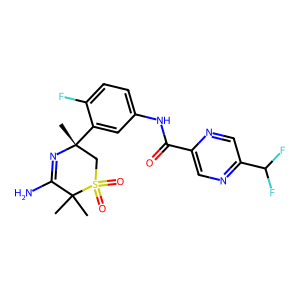


Molecule 5:
SMILES: C[C@@]1(c2cc(NC(=O)c3ccc(OC(F)F)cn3)ccc2F)CS(=O)(=O)CC(N)=N1
HasAmide: True
HasSulfonamide: False
HasAmine: True



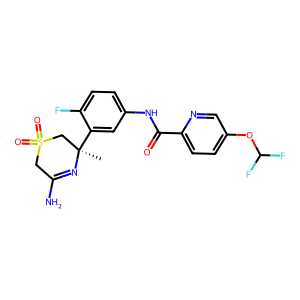

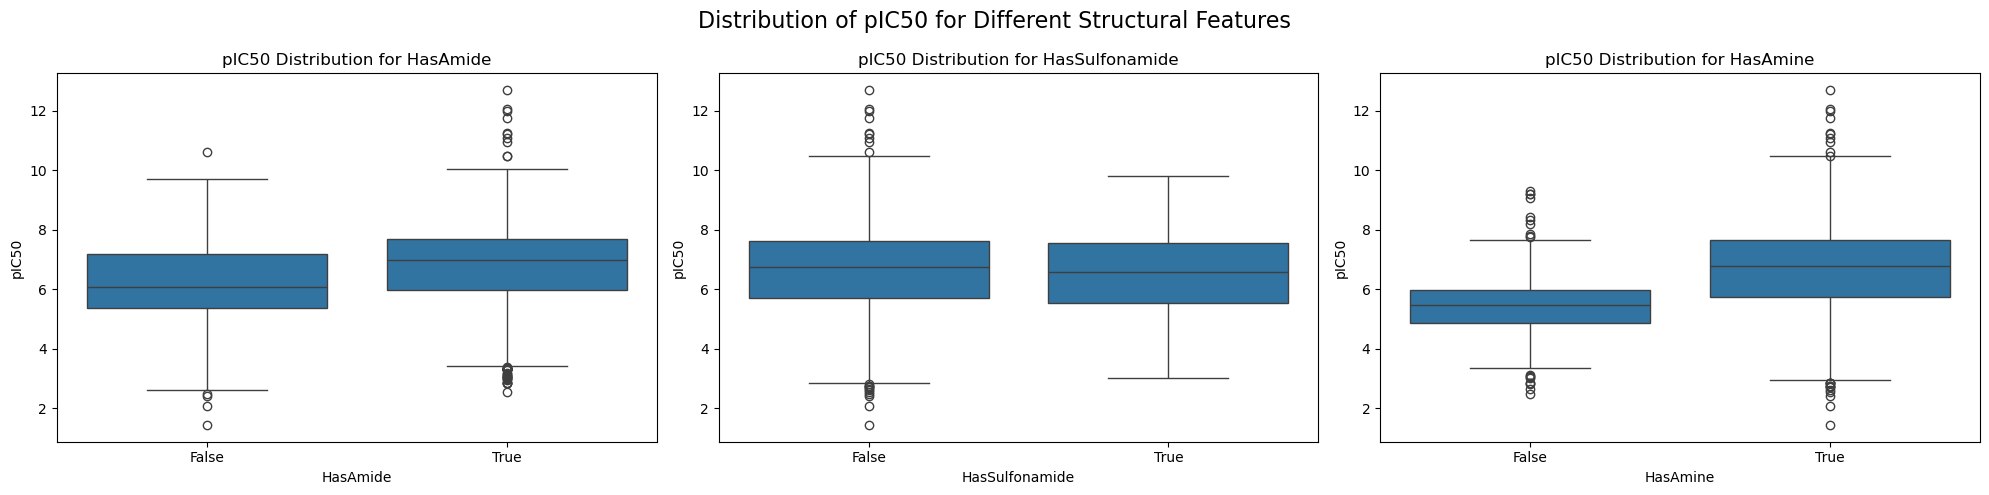

Correlation with pIC50:
pIC50             1.000000
HasAmide          0.201011
HasAmine          0.192469
HasSulfonamide   -0.028789
Name: pIC50, dtype: float64


In [56]:
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display, Image

# First, let's check for the presence of carbon atoms
df['HasCarbon'] = df['ROMol'].apply(lambda x: x.GetSubstructMatch(Chem.MolFromSmarts('C')) != ())

print(f"Molecules with carbon: {df['HasCarbon'].sum()}")
print(f"Molecules without carbon: {(~df['HasCarbon']).sum()}")

# Structural feature detection
def check_substructure(mol, smarts):
    pattern = Chem.MolFromSmarts(smarts)
    return mol.HasSubstructMatch(pattern)

features = {
    'HasAmide': 'C(=O)N',
    'HasSulfonamide': 'S(=O)(=O)N',
    'HasAmine': '[NH2,NH1,NH0]'
}

for feature, smarts in features.items():
    df[feature] = df['ROMol'].apply(lambda x: check_substructure(x, smarts))
    print(f"Molecules with {feature}: {df[feature].sum()}")
    print(f"Molecules without {feature}: {(~df[feature]).sum()}")
    print(f"Average pIC50 with {feature}: {df[df[feature]]['pIC50'].mean():.2f}")
    print(f"Average pIC50 without {feature}: {df[~df[feature]]['pIC50'].mean():.2f}")
    print()

# Check and display the first 5 molecules
for i in range(5):
    mol = df['ROMol'].iloc[i]
    print(f"Molecule {i+1}:")
    print(f"SMILES: {Chem.MolToSmiles(mol)}")
    print(f"HasAmide: {check_substructure(mol, 'C(=O)N')}")
    print(f"HasSulfonamide: {check_substructure(mol, 'S(=O)(=O)N')}")
    print(f"HasAmine: {check_substructure(mol, '[NH2,NH1,NH0]')}")
    print()
    
    img = Draw.MolToImage(mol)
    display(img)
    print()

# Visualize the distribution of pIC50 for molecules with and without these features
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Distribution of pIC50 for Different Structural Features', fontsize=16)

for i, feature in enumerate(features.keys()):
    sns.boxplot(data=df, x=feature, y='pIC50', ax=axs[i])
    axs[i].set_title(f'pIC50 Distribution for {feature}')

plt.tight_layout()
plt.show()

# Calculate correlation between structural features and pIC50
correlation = df[list(features.keys()) + ['pIC50']].corr()['pIC50'].sort_values(ascending=False)
print("Correlation with pIC50:")
print(correlation)

# BACE1 Inhibitor Analysis and Drug Design

## Accomplishments and Scientific Background

### 1. Data Preparation and Molecular Representation

We started with a dataset of BACE1 inhibitors, including SMILES representations of molecules and their corresponding pIC50 values. We used RDKit to convert these SMILES strings into molecular objects (ROMol) for computational analysis.

SMILES (Simplified Molecular Input Line Entry System) is a standard notation for representing molecular structures. Converting these to RDKit molecular objects allows us to programmatically analyze and manipulate the molecular structures.

### 2. Structural Feature Detection

We identified key structural features (amides, sulfonamides, and amines) within our molecules using SMARTS patterns.

SMARTS (SMILES arbitrary target specification) is a language for specifying substructural patterns in molecules. These functional groups are often important in drug-target interactions:
- Amides and sulfonamides can act as hydrogen bond acceptors and donors
- Amines can be protonated at physiological pH, potentially forming salt bridges with the target protein

### 3. Structure-Activity Relationship (SAR) Analysis

We examined the relationship between these structural features and the pIC50 values of the molecules.

SAR analysis helps us understand how changes in chemical structure affect biological activity. The pIC50 value is the negative logarithm of the IC50 (half maximal inhibitory concentration), so higher pIC50 values indicate more potent inhibitors.

### 4. Visualization of Molecular Structures

We visualized the first few molecules in the dataset to get a sense of their structures.

Visual inspection of molecular structures can provide insights into their 3D shape, potential binding modes, and the spatial arrangement of functional groups.

### 5. Statistical Analysis

We calculated average pIC50 values for molecules with and without each structural feature and visualized the distributions using box plots.

This analysis helps us identify which structural features might be contributing to higher potency. Features associated with higher average pIC50 values or a shift in the pIC50 distribution might be important for BACE1 inhibition.

### 6. Correlation Analysis

We calculated correlations between the presence of structural features and pIC50 values.

Correlation analysis quantifies the strength and direction of the relationship between structural features and potency. Strong positive correlations suggest that a feature is associated with higher potency, while negative correlations suggest the opposite.

## Next Steps

1. **Machine Learning Model Development**: 
   Use the structural features and molecular descriptors to build predictive models for pIC50 values. This could involve techniques like Random Forest, Support Vector Machines, or Neural Networks.

2. **Feature Engineering**: 
   Based on our SAR analysis, we might want to engineer more complex features or combine existing ones to better capture the factors influencing potency.

3. **Molecular Docking Studies**: 
   Select the most potent inhibitors and perform molecular docking simulations with the BACE1 protein structure to understand their binding modes.

4. **Pharmacophore Modeling**: 
   Develop a pharmacophore model based on the most potent inhibitors to identify the key spatial arrangements of features important for BACE1 inhibition.

5. **New Compound Design**: 
   Use the insights from our SAR analysis, machine learning models, and pharmacophore modeling to design new potential BACE1 inhibitors.

6. **ADME Property Prediction**: 
   Predict important drug-like properties (Absorption, Distribution, Metabolism, Excretion) for our compounds to ensure they have favorable characteristics for potential drug development.

7. **Experimental Validation**: 
   Propose the most promising new compounds for synthesis and experimental testing to validate our computational predictions.

